# Fit Lorentzprofiel
**Ruben Van der Borght** <br>
**Wiskunde-Fysica, r0829907**

## Inleiding

In [1]:
import numpy as np #Importeer enkele nodige packages.
import math
from scipy.optimize import minimize, fsolve
import matplotlib.pyplot as plt
from scipy.stats import chi2

In dit document wordt de dataset $\texttt{38.txt}$ (zie Bijlage) met metingen van posities $x$ [mm] en intensiteiten $I$ met een arbitraire eenheid [arb.eenh] geanalyseerd. Met een fit worden $\gamma$ de schaalparameter, $A$ de vermenigvuldigheidsfactor, $y_0$ de offset en $x_0$ de verschuivingsparameter berekend. Het Lorentzprofiel is gegeven door
$$I(x_j \vert \gamma,A,y_0,x_0)= \frac{A}{ \pi} \frac{ \gamma}{(x-x_0)^2+ \gamma^2}+y_0. [ref]$$
De paramters worden ook genoteerd als $\theta = (\gamma,A,y_0,x_0)$.
Er is gegeven dat $I$ gemeten is door fotonen te meten en dat elke meting uit een Poissonverdeling $P( I(x \vert \theta))$ komt. [ref] Omdat het minimum van de $I$-waarden ($(78\pm9)$ arb.eenh.) ($1\sigma$-fout) veel groter is dan 10, benaderen we de verdeling met een normale verdeling $N(I(x \vert \theta), I(x \vert \theta))$. De LS-waarde wordt dan ook op dezelfde manier berekend als bij normaal verdeelde waarden.

Het model en de gegevens worden reeds ingeladen.

In [2]:
dataset = np.loadtxt("38.txt", delimiter=" ").T #Laad de dataset.
x,I=dataset[0],dataset[1]

theta = ["gamma","A","y_0","x_0"] #Definieer enkele lijsten die later bij iteraties gebruikt worden
theta_latex = ["\gamma","A","y_0","x_0"]
theta_units=["mm","arb.eenh.\cdot mm","arb.eenh.","mm"]

def intensity(x,gamma,A,y_0,x_0): #Definieer het model
    I = A*gamma/(np.pi*((x-x_0)**2+gamma**2))+y_0
    return I

print(min(I)) #Bereken de kleinste I-waarde

78.0


## Plot van de dataset inclusief fit

In [3]:
def LS_intensity(theta): #Definieer een functie die de Least Square-waarde ofwel \chi^2-waarde berekend bij gegeven \theta.
    gamma,A,y_0,x_0=theta
    LS=0
    for i in range(len(x)):
        LS+=(I[i]-intensity(x[i],gamma,A,y_0,x_0))**2/I[i]
    return LS

De dataset valt te bekijken op Figuur 1. Er wordt aangenomen dat de fout op de $x$-waarden verwaarloosbaar is tegenover de fout op $I$.

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=180, figsize=(8, 5)) #Laad de figuur en plot de datapunten met onzekerheid
ax.errorbar(x, I, yerr=np.sqrt(I), label="Datapunten 38.txt", marker="o", markersize=4, fmt=" ", 
            color="black", ecolor="gray", capsize=2.3, capthick=0.5, linewidth=0.7)

opt = minimize(LS_intensity,(100,1000,0,5)) #Bereken de beste schatter \hat{\theta}. 
gamma,A,y_0,x_0=theta_hat=opt.x              #De gok is gebaseerd op de scatterplot van de datapunten.

x_dots = np.linspace(np.min(x),np.max(x),300) #Plot het Lorentzprofiel voor de beste schatter \hat{\theta}.
ax.plot(x_dots, intensity(x_dots,opt.x[0],opt.x[1],opt.x[2],opt.x[3]), "r", 
        label="Lorentzprofiel:\n"+r"$I(x\vert\hat{\theta})=\frac{%0.2f}{(x-%0.2f)^2+%0.2f^2}+%0.2f$" % (A*gamma/np.pi,x_0,gamma,y_0))

mini = LS_intensity(theta_hat) #Bereken de minimale LS-waarde ofwel \chi^2_0 van \theta{\hat}.

ax.set_ylabel(r"$I$ [arb. eenh.]") #Pas de lay-out van de plot aan.
ax.set_xlabel(r"$x$ [mm]")
ax.legend()
ax.set_title(r"Plot van de dataset 38.txt incl. de fit $I(x\vert\hat{\theta})$",fontsize=14)
plt.figtext(0.5,-0.05, "Figuur 1: Een plot van de datapunten ($x,I$) uit de dataset 38.txt. Er is geen fout op de $x$-waarden\n in de set gegeven, dus er wordt verondersteld dat deze verwaarloosbaar is. De rode curve toont de beste fit aan de datapunten.", wrap=True, horizontalalignment='center', fontsize=12)
plt.tight_layout() ; plt.show()

In [5]:
for i in range(len(theta)):                            #Print de componenten van \theta{\hat}. 
    print("%s\t" % theta[i],"%0.2f" % theta_hat[i])    #Deze componenten zijn nog niet afgerond op het juiste aantal BC.

gamma	 3.42
A	 845.92
y_0	 98.01
x_0	 0.20


Bijgevolg is $\hat{ \theta}$=(3.42 mm, 845.92 arb.eenh.$\cdot$ mm, 98.01 arb.eenh., 0.20 mm), zodat het Lorentzprofiel
$$I(x \vert \hat{ \theta})= \frac{845.92}{ \pi} \frac{3.42}{(x-0.20)^2+3.42^2}+98.01$$
wordt. Bij de waarden hierboven werd nog geen rekening gehouden met de onzekerheden die in de volgende paragraaf zullen gevonden worden. Wanneer deze berekend zijn, wordt het effectieve model met de juiste waarde $\hat{\theta}_{eff}$ gegeven.

## Onzekerheden op de gefitte $\hat{\theta}$

Met behulp van de methode die in het opgaveblad werd besproken (ref.) wordt de onzekerheid op de verschillende parameters achtereenvolgens berekend. Daarvoor werd een plot gemaakt van $\chi^2$ in functie van elke component $\theta_i$ van $\theta$, zoals op Figuur 2 te zien valt.

In [6]:
fig, bx = plt.subplots(nrows=2, ncols=2, dpi=180, figsize=(10, 8))

nu=len(x)-len(theta)              #Bereken de waarde van de 1\sigma-hypercontour
sigma = mini+chi2.ppf(0.68,df=nu) 

theta_uncertainty=[]
bounds = [3,1.5,0.15,24] 

for i in range(len(theta_hat)):
    par=theta_hat[i]
    points = np.linspace(par-par*bounds[i],par+par*bounds[i],300)  #Bereken de grenzen van de plot
    b=list(theta_hat)
    b[i]=points
    
    j = 0 if i%2==0 else 1 #Bepaal de subplot
    k = 1 if i>1 else 0
    
    bx[j][k].plot(points,LS_intensity(b), label=r'$\chi^2( \theta_i)$') #Plot \chi^2(par)
    
    bx[j][k].plot(theta_hat[i],mini,"o", color='red', markersize=3,label=r'minimum') #Plot het minimum van \chi^2(par)
    
    bx[j][k].plot(points,sigma*np.ones(300),'gray', label=r'$1 \sigma$-hypercontour') #Plot de 1\sigma-hypercontour
    
    idx = np.argwhere(np.diff(np.sign(LS_intensity(b) - sigma*np.ones(300)))).flatten() #Bereken de snijpunten en plot ze
    bx[j][k].plot(points[idx[0]],sigma,"o",color='black',markersize=3,label=r'Snijpunten $\chi^2(\theta_i)$ en $1\sigma$-hypercontour')
    bx[j][k].plot(points[idx[1]],sigma,"o",color='black',markersize=3)
    
    
    theta_uncertainty.append((np.format_float_scientific(theta_hat[i]-points[idx[0]],precision=1,unique=True,exp_digits=1),np.format_float_scientific(points[idx[1]]-theta_hat[i],precision=1,unique=True,exp_digits=1))) #Maak een lijst van de onzekerheden
    
    bx[j][k].set_ylabel(r"$\chi^2$ [geen dimensie]") #Verzorg de lay-out van de subplot
    bx[j][k].set_xlabel(r"$%s$ [$%s$]" % (theta_latex[i],theta_units[i]))
    bx[j][k].set_xlim(par-par*bounds[i],par+par*bounds[i])


lines, labels = fig.axes[-1].get_legend_handles_labels() #Verzorg de lay-out van de totale plot
fig.legend(lines, labels,ncol=4, loc ='upper center',bbox_to_anchor=(0.5, 0.945),fontsize=8.5)
fig.suptitle(r'$\chi^2$ in functie van de componenten $\theta_i$ van $\theta$',fontsize=14)
width = {'width': 1}
plt.figtext(0.5,-0.05, r"Figuur 2: Vier plots van $\chi^2$ in functie van elk van de vier componenten van $\theta$. Op de grafieken werd het minimum van de functie aangeduid," "\n" r" dat bij $\theta=\hat{\theta}$ wordt aangenomen. Daarnaast vallen de $1\sigma$-hypercontour en de snijpunten van $\chi^2$ met deze contour te zien. Hieruit worden de onzekerheden op de $\theta_i$'s afgeleid.", wrap=True, horizontalalignment='center', fontsize=12)

Text(0.5, -0.05, "Figuur 2: Vier plots van $\\chi^2$ in functie van elk van de vier componenten van $\\theta$. Op de grafieken werd het minimum van de functie aangeduid,\n dat bij $\\theta=\\hat{\\theta}$ wordt aangenomen. Daarnaast vallen de $1\\sigma$-hypercontour en de snijpunten van $\\chi^2$ met deze contour te zien. Hieruit worden de onzekerheden op de $\\theta_i$'s afgeleid.")

In [7]:
for i in range(len(theta)):  #Print de onzekerheden
    print('%s:\t' % theta[i],'[',theta_uncertainty[i][0],',',theta_uncertainty[i][1],']')

gamma:	 [ 1.8e+0 , 7.8e+0 ]
A:	 [ 5.2e+2 , 5.1e+2 ]
y_0:	 [ 1.0e+1 , 1.0e+1 ]
x_0:	 [ 2.9e+0 , 3.6e+0 ]


De parameters met hun onzekerheden worden dus gegeven door 
$$\gamma=3^{+8}_{-2} \text{ mm} \qquad A=(800 \pm 500) \text{ arb.eenh.} \cdot \text{mm} \qquad y_0=(98 \pm10) \text{ mm} \qquad x_0=0^{+4}_{-3} \text{ mm}\qquad (1\sigma\text{-fout}).$$
Bijgevolg is $\hat{\theta}_{eff}$=(3 mm,800 arb.eenh.$\cdot$mm,98 arb.eenh.,0 mm). Hiermee kan de effectieve fit berekend en geplot worden. Die is
$$I(x \vert \hat{ \theta}_{eff})= \frac{800}{ \pi} \frac{3}{x^2+9}+98$$

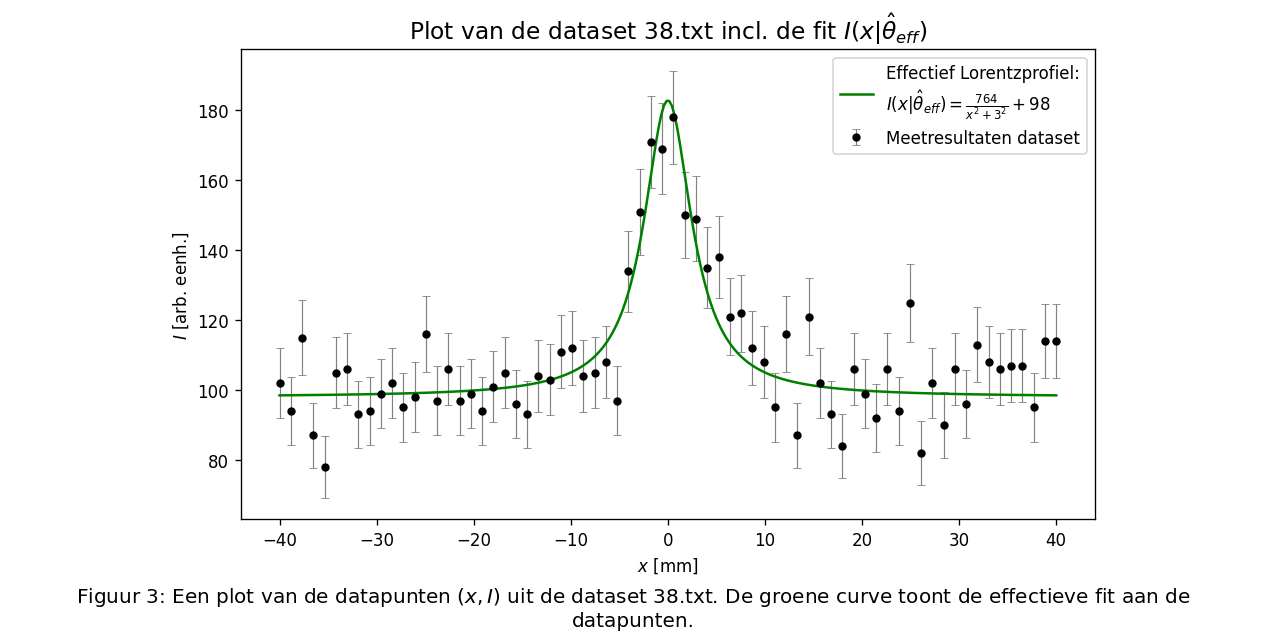

In [8]:
theta_eff=(3,800,98,0)
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=120, figsize=(8, 5)) #Laad de figuur en plot de datapunten met onzekerheid
ax.errorbar(x, I, yerr=np.sqrt(I), label="Meetresultaten dataset",marker="o", markersize=4, fmt=" ", 
            color="black", ecolor="gray", capsize=2.3, capthick=0.5, linewidth=0.7)

ax.plot(x_dots, intensity(x_dots,theta_eff[0],theta_eff[1],theta_eff[2],theta_eff[3]), "green", #Plot de effectieve fit
        label="Effectief Lorentzprofiel:\n"+r"$I(x \vert \hat{ \theta}_{eff})=\frac{%0.0f}{x^2+%0.0f^2}+%0.0f$" % (theta_eff[1]*theta_eff[0]/np.pi,theta_eff[0],theta_eff[2]))

ax.set_ylabel(r"$I$ [arb. eenh.]") #Pas de lay-out van de plot aan.
ax.set_xlabel(r"$x$ [mm]")
ax.legend()
ax.set_title(r"Plot van de dataset 38.txt incl. de fit $I(x\vert\hat{\theta}_{eff})$",fontsize=14)
plt.figtext(0.5,-0.05, "Figuur 3: Een plot van de datapunten ($x,I$) uit de dataset 38.txt. De groene curve toont de effectieve fit aan de datapunten.", wrap=True, horizontalalignment='center', fontsize=12)
plt.tight_layout() ; plt.show()

## Kwaliteit van de fit

Nu wordt onderzocht of de gevonden fit aanvaardbaar is. Daarvoor wordt een rechteenzijdige hypothesetest uitgevoerd. De nulhypothese $H_0$ is dat $\chi^2_0$ een $\chi^2_{\nu}$-verdeling volgt.[ref] Er wordt gewerkt op significantieniveau $\alpha=5\%$. Deze keuze van $\alpha$ zorgt voor een kleine kans dat de fit niet foutief verworpen of aanvaard wordt. [ref] 

In [9]:
chi_2_0=LS_intensity(theta_eff)  #Bereken \chi^2_0
print('chi²_0:\t\t',chi_2_0)

nu=len(x)-len(theta)             #Bereken \chi^2_red
chi_2_red=chi_2_0/nu
print('chi²_red:\t',chi_2_red)

chi²_0:		 63.54571100967008
chi²_red:	 0.9628138031768194


Eerst word het model geëvalueerd met behulp van de teststatistiek $\chi^2_{red}$. Aangezien $\chi^2_{red} \approx 1$, zal de fit goed aansluiten bij de steekproef. Het model is geen overfit ofwel te precies want dan zou $\chi^2_{red} < 1$, en ook geen onderfit ofwel te ruw want dan zou $\chi^2_{red}>1$. 

Vervolgens wordt bepaald of het Lorentz profiel een goed model is voor de dataset met behulp van $p$-waarden. Daarvoor wordt de $p$-waarde $p( \chi^2_{ \nu}> \chi^2_0)$ berekend. Uit het model volgt dat $\nu=N-p=66$

In [11]:
p = chi2.sf(chi_2_0,df=nu)  #Bereken de p-waarde
print(p)

0.5628016941707908


De gevonden $p$-waarde is groter dan het significantieniveau $\alpha=5\%$, dus de gevonden fit wordt aanvaard. Omdat het model aan de twee evaluatiecriteria voldoet, wordt besloten dat  Lorentzmodel goed aansluit bij de gegeven dataset.

## Conclusie

Het Lorentzmodel beschrijft de dataset $\texttt{38.txt}$ goed. Voor de beste fit is  $\hat{\theta}_{eff}$=(3 mm,800 arb.eenh.$\cdot$mm,98 arb.eenh.,0 mm). Het Lorentzmodel wordt dan 
$$I(x \vert \hat{ \theta}_{eff})= \frac{800}{ \pi} \frac{3}{x^2+9}+98.$$
De fit wordt aanvaard op $\alpha=5\%$

## Referenties

## Bijlage